In [1]:
# Author: Gael Varoquaux gael.varoquaux@normalesup.org
# License: BSD 3 clause
%matplotlib inline
import datetime

import numpy as np
import matplotlib.pyplot as plt
try:
    from matplotlib.finance import quotes_historical_yahoo
except ImportError:
    from matplotlib.finance import quotes_historical_yahoo_ochl as quotes_historical_yahoo
from matplotlib.collections import LineCollection

from sklearn import cluster, covariance, manifold


In [3]:
# Retrieve the data from Internet

# Choose a time period reasonnably calm (not too long ago so that we get
# high-tech firms, and before the 2008 crash)
d1 = datetime.datetime(2003, 1, 1)
d2 = datetime.datetime(2008, 1, 1)

# kraft symbol has now changed from KFT to MDLZ in yahoo
symbol_dict = {
    'TOT': 'Total',
    'XOM': 'Exxon',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'VLO': 'Valero Energy',
    'MSFT': 'Microsoft',
    'IBM': 'IBM',
    'TWX': 'Time Warner',
    'CMCSA': 'Comcast',
    'CVC': 'Cablevision',
    'YHOO': 'Yahoo',
    'DELL': 'Dell',
    'HPQ': 'HP',
    'AMZN': 'Amazon',
    'TM': 'Toyota',
    'CAJ': 'Canon',
    'MTU': 'Mitsubishi',
    'SNE': 'Sony',
    'F': 'Ford',
    'HMC': 'Honda',
    'NAV': 'Navistar',
    'NOC': 'Northrop Grumman',
    'BA': 'Boeing',
    'KO': 'Coca Cola',
    'MMM': '3M',
    'MCD': 'Mc Donalds',
    'PEP': 'Pepsi',
    'MDLZ': 'Kraft Foods',
    'K': 'Kellogg',
    'UN': 'Unilever',
    'MAR': 'Marriott',
    'PG': 'Procter Gamble',
    'CL': 'Colgate-Palmolive',
    'GE': 'General Electrics',
    'WFC': 'Wells Fargo',
    'JPM': 'JPMorgan Chase',
    'AIG': 'AIG',
    'AXP': 'American express',
    'BAC': 'Bank of America',
    'GS': 'Goldman Sachs',
    'AAPL': 'Apple',
    'SAP': 'SAP',
    'CSCO': 'Cisco',
    'TXN': 'Texas instruments',
    'XRX': 'Xerox',
    'LMT': 'Lookheed Martin',
    'WMT': 'Wal-Mart',
    'WBA': 'Walgreen',
    'HD': 'Home Depot',
    'GSK': 'GlaxoSmithKline',
    'PFE': 'Pfizer',
    'SNY': 'Sanofi-Aventis',
    'NVS': 'Novartis',
    'KMB': 'Kimberly-Clark',
    'R': 'Ryder',
    'GD': 'General Dynamics',
    'RTN': 'Raytheon',
    'CVS': 'CVS',
    'CAT': 'Caterpillar',
    'DD': 'DuPont de Nemours'}

symbols, names = np.array(list(symbol_dict.items())).T

In [4]:
quotes = [quotes_historical_yahoo(symbol, d1, d2, asobject=True)
          for symbol in symbols]

stock_open = np.array([q.open for q in quotes]).astype(np.float)
stock_close = np.array([q.close for q in quotes]).astype(np.float)

/Users/chengjun/anaconda/lib/python2.7/site-packages/matplotlib/finance.py:485: MatplotlibDeprecationWarning: This function has been deprecated in 1.4 in favor of `quotes_historical_yahoo_ochl`, which maintains the original argument order, or `quotes_historical_yahoo_ohlc`, which uses the open-high-low-close order. This function will be removed in 1.5
  mplDeprecation)


In [5]:
import pickle
output = open('/Users/chengjun/GitHub/cjc2016/data/stock_open.pkl', 'wb')
# Pickle dictionary using protocol 0.
pickle.dump(stock_open, output)
output.close()

output = open('/Users/chengjun/GitHub/cjc2016/data/stock_close.pkl', 'wb')
# Pickle dictionary using protocol 0.
pickle.dump(stock_close, output)
output.close()

# Load Pickle Data

In [5]:
import pickle
data = open('/Users/chengjun/GitHub/cjc2016/data/stock_open.pkl', 'r')
# Pickle dictionary using protocol 0.
stock_open = pickle.load(data)
data.close()

data = open('/Users/chengjun/GitHub/cjc2016/data/stock_close.pkl', 'r')
# Pickle dictionary using protocol 0.
stock_close = pickle.load(data)
data.close()

In [6]:
# The daily variations of the quotes are what carry most information
variation = stock_close - stock_open

In [7]:
variation

array([[ 0.12936386, -0.03172999,  0.20258755, ..., -0.14865278,
         0.07157136, -0.44045379],
       [ 0.63269122,  0.0799928 ,  0.99630258, ..., -1.11184795,
        -0.75570651,  1.01629786],
       [ 0.34160551,  0.01423356,  0.20638595, ..., -0.79103983,
        -0.43507428, -0.57986219],
       ..., 
       [ 0.91294843, -0.13416206,  0.29449672, ..., -0.62319818,
        -0.33666256, -0.18624163],
       [ 0.00920966, -0.05986028, -0.16116061, ..., -0.30019468,
        -0.02633234, -0.08426518],
       [ 0.06352973,  0.01270637, -0.01694387, ..., -0.19319241,
        -0.05201374, -0.63159692]])

# GraphLassoCV

> Sparse inverse covariance w/ cross-validated choice of the l1 penalty

In [14]:
# Learn a graphical structure from the correlations
edge_model = covariance.GraphLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

GraphLassoCV(alphas=4, assume_centered=False, cv=None, enet_tol=0.0001,
       max_iter=100, mode='cd', n_jobs=1, n_refinements=4, tol=0.0001,
       verbose=False)

# Cluster using affinity propagation


In [9]:
_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

Cluster 1: Pepsi, Coca Cola, Kellogg
Cluster 2: Apple, Amazon, Yahoo
Cluster 3: GlaxoSmithKline, Novartis, Sanofi-Aventis
Cluster 4: Comcast, Time Warner, Cablevision
Cluster 5: ConocoPhillips, Chevron, Total, Valero Energy, Exxon
Cluster 6: CVS, Walgreen
Cluster 7: Navistar, Sony, Marriott, Caterpillar, Canon, Toyota, Honda, Mitsubishi, Xerox, Unilever
Cluster 8: Kimberly-Clark, Colgate-Palmolive, Procter Gamble
Cluster 9: American express, Ryder, Goldman Sachs, Wal-Mart, General Electrics, Pfizer, Wells Fargo, DuPont de Nemours, Bank of America, AIG, Home Depot, Ford, JPMorgan Chase, Mc Donalds
Cluster 10: Microsoft, SAP, 3M, IBM, Texas instruments, HP, Dell, Cisco
Cluster 11: Raytheon, Boeing, Lookheed Martin, General Dynamics, Northrop Grumman
Cluster 12: Kraft Foods


In [10]:
# Find a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

In [11]:
# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

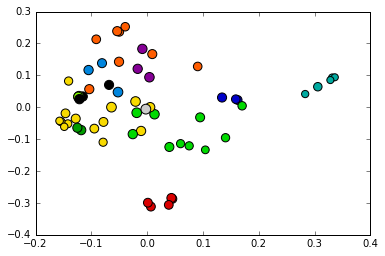

In [12]:
# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.spectral)
plt.show()

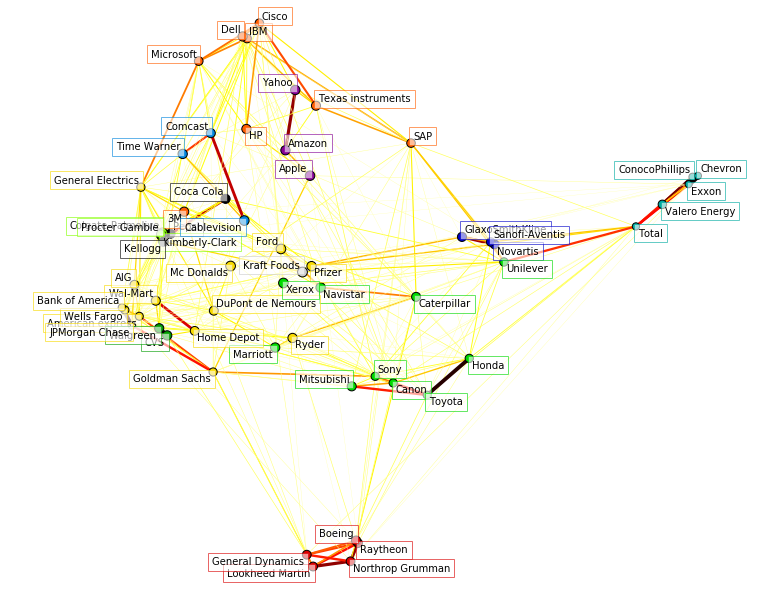

In [13]:
# Visualization
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
#a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()